# Project : Registration of anatomical and functional pelvis images

Charline Curaut 3810013

### Useful libraires and functions

In [127]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
from scipy.optimize import fsolve
from scipy.optimize import minimize
import math
import cv2
import skimage.measure 
#import imutils

In [2]:
def load_nii(difficulty, folder, f_name):
    
    path = 'EXAMPLE-b0-T2/' + difficulty + '/' + folder + '/' + f_name
    img = nib.load(path)
    #print(f'image affine before canonical \n{img.affine}')
    print(f'voxel orientation : {nib.aff2axcodes(img.affine)}')
    canonical_img = nib.as_closest_canonical(img)
    #print(f'image affine after canonical \n{canonical_img.affine}')
    print(f'voxel orientation : {nib.aff2axcodes(canonical_img.affine)}')
    
    return canonical_img.get_fdata(), canonical_img.affine

## Manipulation of data to get familiarized

Let's first put the images along the same voxel orientation.

In [3]:
minor_b0, affine_b0 = load_nii('minor', '1-2-14_off_210111', '1-2-14_off_210111_b0DWI.nii')
#print(f'image affine after canonical \n{img.affine}')
print(minor_b0.shape)

minor_T2, affine_T2 = load_nii('minor', '1-2-14_off_210111', '1-2-14_off_210111_coroT2Cube.nii')
print(minor_T2.shape)

minor_T2_mask, affine_T2_mask = load_nii('minor', '1-2-14_off_210111', '1-2-14_off_210111_T2Mask.nii')
print(minor_T2_mask.shape)

minor_Segmentation_T2, affine_T2_seg = load_nii('minor', '1-2-14_off_210111', '1-2-14_off_210111_Segmentation.nii')
print(minor_Segmentation_T2.shape)

voxel orientation : ('L', 'A', 'S')
voxel orientation : ('R', 'A', 'S')
(256, 256, 75)
voxel orientation : ('R', 'A', 'S')
voxel orientation : ('R', 'A', 'S')
(400, 179, 400)
voxel orientation : ('R', 'A', 'S')
voxel orientation : ('R', 'A', 'S')
(400, 179, 400)
voxel orientation : ('R', 'A', 'S')
voxel orientation : ('R', 'A', 'S')
(400, 179, 400)


In [4]:
print(f'b0 : {len(np.unique(minor_b0))} values in {np.unique(minor_b0)}\n')
print(f'T2 : {len(np.unique(minor_T2))} values in {np.unique(minor_T2)}\n')
print(f'T2 mask : {len(np.unique(minor_T2_mask))} values in {np.unique(minor_T2_mask)}\n')
print(f'T2 seg : {len(np.unique(minor_Segmentation_T2))} values in {np.unique(minor_Segmentation_T2)}')

b0 : 16480 values in [ 1075.  1076.  1077. ... 32457. 32560. 32767.]

T2 : 17676463 values in [0.00000000e+00 4.57295858e-35 1.13290205e-30 ... 9.91978027e+03
 9.93124707e+03 9.94759961e+03]

T2 mask : 2 values in [0. 1.]

T2 seg : 20 values in [ 0.  5.  9. 10. 14. 15. 18. 21. 24. 27. 33. 36. 42. 43. 44. 45. 49. 54.
 55. 61.]


### Visualization of a slice for each data (b0, T2 and T2_mask) (they don't necessarily correspond between one another) :

#### Axial slices

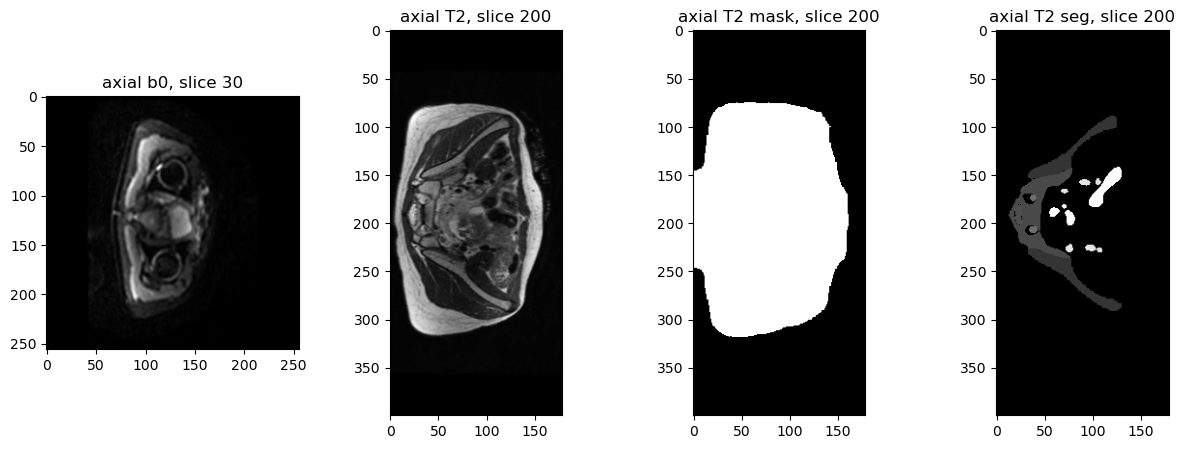

In [5]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,4,1)
axial_b0 = minor_b0[:,:,30]
plt.imshow(axial_b0, cmap="gray")
plt.title("axial b0, slice 30")

plt.subplot(1,4,2)
axial_T2 = minor_T2[:,:,200]
plt.imshow(axial_T2, cmap="gray")
plt.title("axial T2, slice 200")

plt.subplot(1,4,3)
axial_T2_mask = minor_T2_mask[:,:,200]
plt.imshow(axial_T2_mask, cmap="gray")
plt.title("axial T2 mask, slice 200")

plt.subplot(1,4,4)
axial_seg_T2 = minor_Segmentation_T2[:,:,200]
plt.imshow(axial_seg_T2, cmap="gray")
plt.title("axial T2 seg, slice 200")

plt.show()

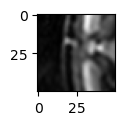

In [6]:
fig = plt.figure(figsize=(1,5))
plt.imshow(axial_b0[100:150,50:100], cmap='gray')
plt.show()

The coordinates are in RAS+ so we have (x,y,z) with x that increases to the Right, y that increases to the Anterior part, and z that increases to Superior part. Here, the images are displayed with the x axis being the vertical axis, and the y axis being the horizontal axis. 

#### Coronal slices

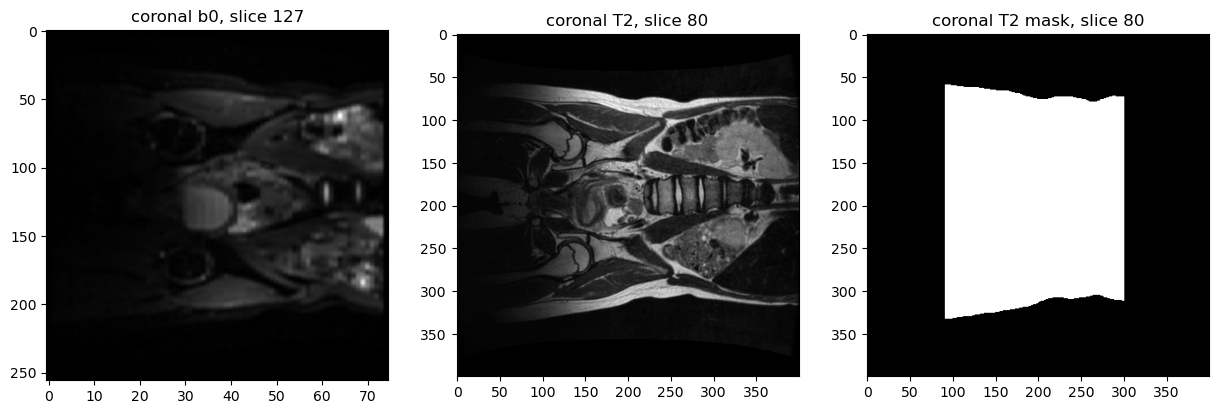

In [7]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
coronal_b0 = minor_b0[:,127,:]
plt.imshow(coronal_b0, cmap="gray")
plt.gca().set_aspect(aspect=0.3)
plt.title("coronal b0, slice 127")

plt.subplot(1,3,2)
coronal_T2 = minor_T2[:,80,:]
plt.imshow(coronal_T2, cmap="gray")
plt.title("coronal T2, slice 80")

plt.subplot(1,3,3)
coronal_T2_mask = minor_T2_mask[:,80,:]
plt.imshow(coronal_T2_mask, cmap="gray")
plt.title("coronal T2 mask, slice 80")

plt.show()

#### Sagittal slices

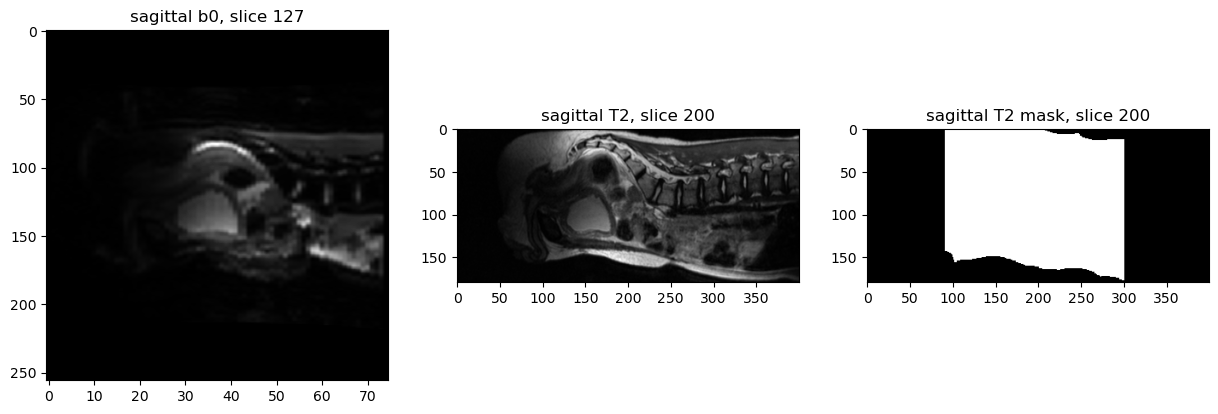

In [8]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sagittal_b0 = minor_b0[127,:,:]
plt.imshow(sagittal_b0, cmap="gray")
plt.gca().set_aspect(aspect=0.3)
plt.title("sagittal b0, slice 127")

plt.subplot(1,3,2)
sagittal_T2 = minor_T2[200,:,:]
plt.imshow(sagittal_T2, cmap="gray")
plt.title("sagittal T2, slice 200")

plt.subplot(1,3,3)
sagittal_T2_mask = minor_T2_mask[200,:,:]
plt.imshow(sagittal_T2_mask, cmap="gray")
plt.title("sagittal T2 mask, slice 200")

plt.show()

#### Cuting axial slice T2 according to given mask

In [9]:
# on manipule chaque coupe coronale pour éliminer des coupes axiales.

def cut_T2_coro(T2, T2_mask, coordinates=False) :
    """ 
    Search for each coronal slice the first and last y-coordinate pixel (which correspond to z-corrdinate voxel)
    Return a cut version of T2 (with less axial slices)
    """

    z_max = 0
    z_min = T2.shape[2]

    for i in range(T2.shape[1]) :
        slice_coro = T2[:,i,:]
        slice_coro_mask = T2_mask[:,i,:]

        for y in range(slice_coro.shape[1]) :
            if 1.0 in slice_coro_mask[:,y]:
                if y < z_min :
                    z_min = y
                break

        for y in range(slice_coro.shape[1]-1,-1,-1) :
            if 1.0 in slice_coro_mask[:,y] :
                if y > z_max :
                    z_max = y
                break
     
    if coordinates :
        return z_min, z_max

    return T2[:,:,z_min:z_max], T2_mask[:,:,z_min:z_max]

In [10]:
minor_T2_cut, minor_T2_mask_cut = cut_T2_coro(minor_T2, minor_T2_mask)
print(minor_T2_cut.shape)

(400, 179, 209)


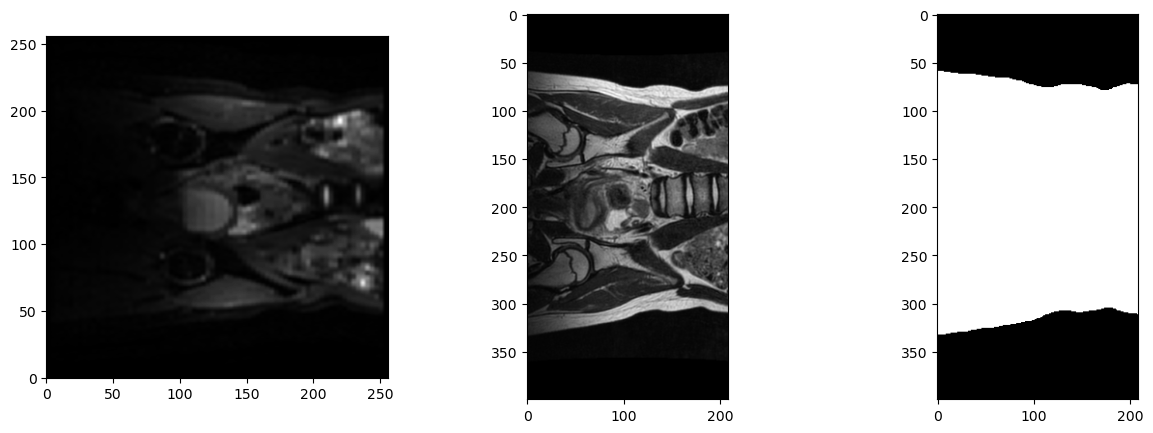

In [11]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
coronal_b0 = minor_b0[:,127,:]
plt.imshow(coronal_b0, cmap="gray", extent=(0,256,0,256))

plt.subplot(1,3,2)
coronal_T2_cut = minor_T2_cut[:,80,:]
plt.imshow(coronal_T2_cut, cmap="gray")

plt.subplot(1,3,3)
coronal_T2_mask_cut = minor_T2_mask_cut[:,80,:]
plt.imshow(coronal_T2_mask_cut, cmap="gray")

plt.show()

Right now there are 75 axial b0 slices of thickness 3.5 mm, and 209 axial T2 slices of thickness 0.8 mm. We still have to resample T2. Which mean that the size of the coronal region covered by b0 is $75 * 3.5 = 262.5 mm$ and the one covered by T2 is $ 209 * 0.8 = 167.2 mm$. The surface of T2 is now lesser than that of b0. 

Ce n'est peut être pas la bonne méthode (ajuster la taille des images jusqu'à avoir une surface environ équivalente) pour faire le ré-échantillonage.
--> à la place : utiliser la matrice affine qui fait passer les coordonnées des voxels dans l'espace Scanner RAS+ --> ça met les deux images en relation et on peut comparer les slices axiales entre elles.

## Pre-processing for the registration

### Resampling of T2

In [12]:
x = np.array(
    [[[0,0,4,4],[0,0,4,4],[1,1,5,5],[1,1,5,5]],
     [[0,0,4,4],[0,0,4,4],[1,1,5,5],[1,1,5,5]],
     [[2,2,6,6],[2,2,6,6],[3,3,7,7],[3,3,7,7]],
     [[2,2,6,6],[2,2,6,6],[3,3,7,7],[3,3,7,7]]] )
print(x[:,:,0])

[[0 0 1 1]
 [0 0 1 1]
 [2 2 3 3]
 [2 2 3 3]]


In [13]:
resample_x0_5 = scipy.ndimage.zoom(x, (0.5, 0.5, 0.5), order=1)
#print(resample_x0_5)
print(resample_x0_5[:,:,0])

[[0 1]
 [2 3]]


In [14]:
## voxel size T2 : 0.88 mm x 0.85 mm x 0.88 mm
## voxel size b0 : 1.25 mm x 1.25 mm x 3.5 mm

scale_sagittal = 0.88 / 1.25
scale_coronal = 0.85 / 1.25
scale_axial = 0.88 / 3.5

print(f'sagittal scale = {scale_sagittal}')
print(f'coronal scale = {scale_coronal}')
print(f'axial scale = {scale_axial}\n')

tmp_T2 = minor_T2.copy()
tmp_T2_mask = minor_T2_mask.copy()


print(f'T2 size before re-sampling :\t{tmp_T2.shape} voxels\t{tuple(np.array(tmp_T2.shape) * [0.88, 0.85, 0.88])} mm')
resampled_T2 = scipy.ndimage.zoom(tmp_T2, (scale_sagittal, scale_coronal, scale_axial), order=1)
print(f'T2 size after re-sampling :\t{resampled_T2.shape} voxels\t{tuple(np.array(resampled_T2.shape) * [1.25, 1.25, 3.5])} mm\n')

print(f'mask T2 size before re-sampling :\t{tmp_T2_mask.shape} voxels\t{tuple(np.array(tmp_T2_mask.shape) * [0.88, 0.85, 0.88])} mm')
resampled_T2_mask = scipy.ndimage.zoom(tmp_T2_mask, (scale_sagittal, scale_coronal, scale_axial), order=1)
print(f'mask T2 size after re-sampling :\t{resampled_T2_mask.shape} voxels\t{tuple(np.array(resampled_T2_mask.shape) * [1.25, 1.25, 3.5])} mm\n')

print(f'b0 size : \t{minor_b0.shape} voxels \t{tuple(np.array(minor_b0.shape) * [1.25, 1.25, 3.5])} mm')

sagittal scale = 0.704
coronal scale = 0.6799999999999999
axial scale = 0.25142857142857145

T2 size before re-sampling :	(400, 179, 400) voxels	(352.0, 152.15, 352.0) mm
T2 size after re-sampling :	(282, 122, 101) voxels	(352.5, 152.5, 353.5) mm

mask T2 size before re-sampling :	(400, 179, 400) voxels	(352.0, 152.15, 352.0) mm
mask T2 size after re-sampling :	(282, 122, 101) voxels	(352.5, 152.5, 353.5) mm

b0 size : 	(256, 256, 75) voxels 	(320.0, 320.0, 262.5) mm


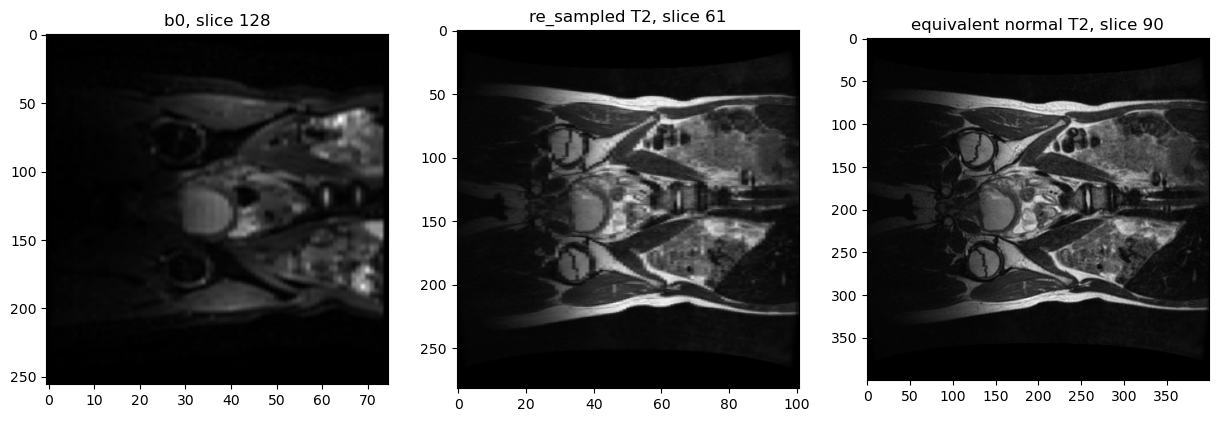

In [15]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
coronal_b0 = minor_b0[:,128,:]
plt.imshow(coronal_b0, cmap="gray")
plt.gca().set_aspect(aspect=0.3)
plt.title("b0, slice 128")

plt.subplot(1,3,2)
coronal_resampled_T2 = resampled_T2[:,61,:]
plt.imshow(coronal_resampled_T2, cmap="gray")
plt.gca().set_aspect(aspect=0.375)
plt.title("re_sampled T2, slice 61")

plt.subplot(1,3,3)
coronal_T2 = minor_T2[:,90,:]
plt.imshow(coronal_T2, cmap="gray")
plt.title("equivalent normal T2, slice 90")

plt.show()

### Region of interest (automated with mask)

In [16]:
minor_T2_cut, minor_T2_mask_cut = cut_T2_coro(resampled_T2, resampled_T2_mask)
print(resampled_T2.shape)
print(minor_T2_cut.shape)
#plt.imshow(minor_T2_cut[:,61,:], cmap='gray')
#plt.gca().set_aspect(aspect=0.375)

(282, 122, 101)
(282, 122, 52)


In [17]:
print([2,3,4] * np.identity(3))

[[2. 0. 0.]
 [0. 3. 0.]
 [0. 0. 4.]]


In [18]:
## To automate with the affine matrix, we need to modify that of T2 because we resampled it
print(f'affine of original T2 : \n{affine_T2}')
M = affine_T2[0:3,0:3]
T = affine_T2[0:3,3]

## it's like doing a transformation then rescaling
## so we just have to multiply by the scaling factor
zooming_matrix = [1./scale_sagittal, 1./scale_coronal, 1./scale_axial] * np.identity(3) 
M = np.dot(M,zooming_matrix)

affine_T2_resampled = np.zeros_like(affine_T2)
affine_T2_resampled[0:3,0:3] = M
affine_T2_resampled[0:3,3] = T
affine_T2_resampled[3,3] = 1
print(f'affine of resampled T2 : \n{affine_T2_resampled}')

affine of original T2 : 
[[   0.88          0.           -0.         -175.97200012]
 [   0.            0.85000002   -0.          -91.72620392]
 [   0.            0.            0.88       -225.76399231]
 [   0.            0.            0.            1.        ]]
affine of resampled T2 : 
[[   1.24999999    0.            0.         -175.97200012]
 [   0.            1.25000004    0.          -91.72620392]
 [   0.            0.            3.49999998 -225.76399231]
 [   0.            0.            0.            1.        ]]


In [19]:
## transforming the voxel coordinates (T2) to RAS coordinates via affine matrix to have z_min and z_max (to cut coronal slices)

z_min_resampled_T2, z_max_resampled_T2 = cut_T2_coro(resampled_T2, resampled_T2_mask, coordinates=True)
print(f'resampled T2 : z_min = {z_min_resampled_T2} and z_max = {z_max_resampled_T2}') ## result coherent with previous cut (decomment imshow of "region of interest")

(_,_,z_min_RAS,_) = np.dot(affine_T2_resampled,(0, 0, z_min_resampled_T2,1))
(_,_,z_max_RAS,_) = np.dot(affine_T2_resampled,(0, 0, z_max_resampled_T2,1))

print(f'RAS : corresponding z_min = {z_min_RAS} and z_max = {z_max_RAS}') ## coherent result

resampled T2 : z_min = 23 and z_max = 75
RAS : corresponding z_min = -145.26399274576795 and z_max = 36.73600626804608


In [20]:
## transforming founded z_min and z_max to RAS coordinates to voxel coordinates (b0) to cut coronal slices

inverse_affine_b0 = np.linalg.inv(affine_b0)
(_,_,z_min_b0,_) = np.dot(inverse_affine_b0, (0,0,z_min_RAS,1))
(_,_,z_max_b0,_) = np.dot(inverse_affine_b0, (0,0,z_max_RAS,1))
print(f' b0 : z_min = {z_min_b0} and z_max = {z_max_b0}')
z_min_b0 = int(np.rint(z_min_b0))
z_max_b0 = int(np.rint(z_max_b0))
print(f' b0 : rounded z_min = {z_min_b0} and rounded z_max = {z_max_b0}')

 b0 : z_min = 19.109387150541536 and z_max = 71.10935918080328
 b0 : rounded z_min = 19 and rounded z_max = 71


These results are quite coherent. Both images now have the same voxel size and after the cut, they have the same number of axial slices with $75 - 23 = 52$ slices for T2 and $71 - 19 = 52$ slices for b0 (we just need to round the result for b0). 

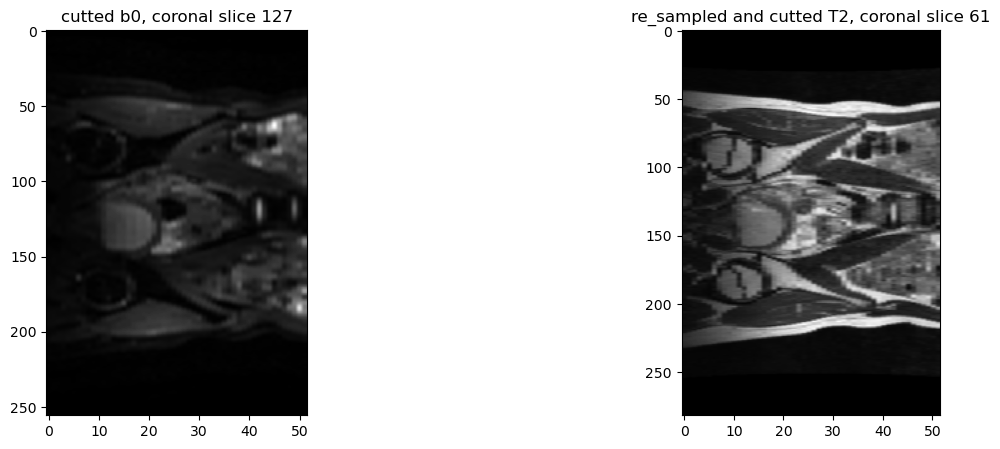

In [21]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
coronal_b0_cut = minor_b0[:,127,z_min_b0:z_max_b0]
plt.imshow(coronal_b0_cut, cmap='gray')
plt.gca().set_aspect(aspect=0.3)

plt.title("cutted b0, coronal slice 127")

plt.subplot(1,2,2)
coronal_resampled_T2_cut = resampled_T2[:,61,z_min_resampled_T2:z_max_resampled_T2]
plt.imshow(coronal_resampled_T2_cut, cmap="gray")
plt.gca().set_aspect(aspect=0.275)
plt.gca().xaxis.set_ticks([0, 10, 20, 30, 40, 50])
plt.title("re_sampled and cutted T2, coronal slice 61")

plt.show()

In [22]:
print(f'cutted b0 shape : {minor_b0[:,:,z_min_b0:z_max_b0].shape}')
print(f'cutted and re_sampled T2 shape : {resampled_T2[:,:,z_min_resampled_T2:z_max_resampled_T2].shape}')

cutted b0 shape : (256, 256, 52)
cutted and re_sampled T2 shape : (282, 122, 52)


#

## 2D-2D registration

### Axial slices

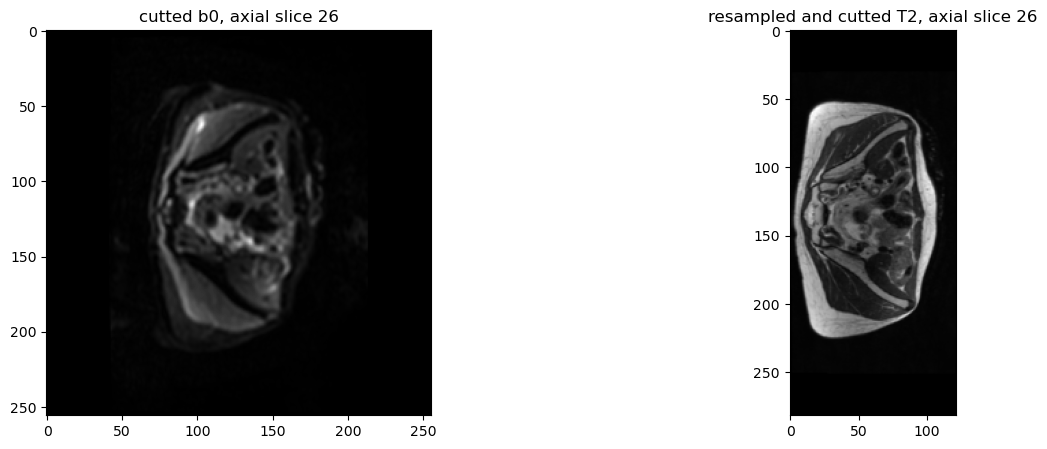

In [23]:
## We are going to try a first 2D-2D registration with the same axial slice of the previous cutted coronal images
## Here are the first two images we'll try to register

minor_b0_cut = minor_b0[:,:,z_min_b0:z_max_b0]
minor_resampled_T2_cut = resampled_T2[:,:,z_min_resampled_T2:z_max_resampled_T2]

fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
axial_b0_cut_23 = minor_b0_cut[:,:,26]
plt.imshow(axial_b0_cut_23, cmap='gray')
plt.title("cutted b0, axial slice 26")

plt.subplot(1,2,2)
axial_resampled_T2_cut_23 = minor_resampled_T2_cut[:,:,26]
plt.imshow(axial_resampled_T2_cut_23, cmap="gray")
plt.title("resampled and cutted T2, axial slice 26")

plt.show()

Mutual Information I for images A and B : I(A,B) = H(A) + H(B) - H(A,B) where H is Shannon entropy.
Shannon entropy --> scipy.stats.entropy(pk) where pk is the probability distribution.

### Solo image distribution

In [24]:
def image_distribution(img, verbose=0) :
    dico = dict()
    N = img.shape[0] * img.shape[1]
    
    for val in np.unique(img) :
        dico[val] = np.sum(np.where(img==val, 1, 0)) / N
        
    P = list(dico.values())
    
    if verbose > 0 :
        print(np.sum(P))
        
    return P

In [25]:
#creation of images distribution

P_b0 = image_distribution(axial_b0_cut_23, verbose=1)
#print(P_b0)
P_T2 = image_distribution(axial_resampled_T2_cut_23, verbose=1)
#print(P_T2)

1.0
0.9999999999999998


In [26]:
# Entropy for each image

H_b0_0 = scipy.stats.entropy(P_b0, base=2)
H_T2_0 = scipy.stats.entropy(P_T2, base=2)

print(H_b0_0)
print(H_T2_0)

8.31303084875563
12.32351671281142


### Padding to have images of same size

In [27]:
def padding(img1, img2) :
    """
    Padding img1 and/or img2 to have same shape
    """
    
    tmp1 = img1.copy()
    tmp2 = img2.copy()
    h1, w1 = img1.shape
    h2, w2 = img2.shape
    pad_h = h2-h1
    pad_w = w2-w1
    
    
    if pad_h < 0 :
        ## h2 < h1
        if pad_h % 2 == 0 :
            pad_h = np.abs(pad_h)//2
            tmp = np.vstack(( np.zeros((pad_h,w2)), tmp2, np.zeros((pad_h,w2)) ))
        else :
            pad_h = (np.abs(pad_h) + 1) // 2
            tmp = np.vstack(( np.zeros((pad_h,w2)), tmp2, np.zeros((pad_h-1,w2)) ))
            
        if pad_w < 0 :
            ## w2 < w1
            if pad_w % 2 == 0 :
                pad_w = np.abs(pad_w)//2
                nv_img2 = np.hstack(( np.zeros((tmp.shape[0],pad_w)), tmp, np.zeros((tmp.shape[0],pad_w)) ))
            else :
                pad_w = (np.abs(pad_w) + 1) // 2
                nv_img2 = np.hstack(( np.zeros((tmp.shape[0],pad_w)), tmp, np.zeros((tmp.shape[0],pad_w-1)) ))
                
            return tmp1, nv_img2
        
        elif pad_w == 0 :
            return tmp1, tmp
        
        else :
            ## w2 > w1
            if pad_w % 2 == 0 :
                pad_w = np.abs(pad_w)//2
                nv_img1 = np.hstack(( np.zeros((h1,pad_w)), tmp1, np.zeros((h1,pad_w)) ))
            else :
                pad_w = (np.abs(pad_w) + 1) // 2
                nv_img1 = np.hstack(( np.zeros((h1,pad_w)), tmp1, np.zeros((h1,pad_w-1)) ))
                
            return nv_img1, tmp
        
    elif pad_h == 0 :
        if pad_w < 0 :
            ## w2 < w1
            if pad_w % 2 == 0 :
                pad_w = np.abs(pad_w)//2
                nv_img2 = np.hstack(( np.zeros((h2,pad_w)), tmp2, np.zeros((h2,pad_w)) ))
            else :
                pad_w = (np.abs(pad_w) + 1) // 2
                nv_img2 = np.hstack(( np.zeros((h2,pad_w)), tmp2, np.zeros((h2,pad_w-1)) ))
                
            return tmp1, nv_img2
        
        elif pad_w == 0 :
            return tmp1, tmp
        
        else :
            ## w2 > w1
            if pad_w % 2 == 0 :
                pad_w = np.abs(pad_w)//2
                nv_img1 = np.hstack(( np.zeros((h1,pad_w)), tmp1, np.zeros((h1,pad_w)) ))
            else :
                pad_w = (np.abs(pad_w) + 1) // 2
                nv_img1 = np.hstack(( np.zeros((h1,pad_w)), tmp1, np.zeros((h1,pad_w-1)) ))
                
            return nv_img1, tmp2
        
    else :
        ## h2 > h1
        if pad_h % 2 == 0 :
            pad_h = np.abs(pad_h)//2
            tmp = np.vstack(( np.zeros((pad_h,w1)), tmp1, np.zeros((pad_h,w1)) ))
        else :
            pad_h = (np.abs(pad_h) + 1) // 2
            tmp = np.vstack(( np.zeros((pad_h,w1)), tmp1, np.zeros((pad_h-1,w1)) ))
        
        
        if pad_w < 0 :
            ## w2 < w1
            if pad_w % 2 == 0 :
                pad_w = np.abs(pad_w)//2
                nv_img2 = np.hstack(( np.zeros((h2,pad_w)), tmp2, np.zeros((h2,pad_w)) ))
            else :
                pad_w = (np.abs(pad_w) + 1) // 2
                nv_img2 = np.hstack(( np.zeros((h2,pad_w)), tmp2, np.zeros((h2,pad_w-1)) ))
                
            return tmp, nv_img2
        
        elif pad_w == 0 :
            return tmp, tmp2
        
        else :
            ## w2 > w1
            if pad_w % 2 == 0 :
                pad_w = np.abs(pad_w)//2
                nv_img1 = np.hstack(( np.zeros((tmp.shape[0],pad_w)), tmp1, np.zeros((tmp.shape[0],pad_w)) ))
            else :
                pad_w = (np.abs(pad_w) + 1) // 2
                nv_img1 = np.hstack(( np.zeros((tmp.shape[0],pad_w)), tmp1, np.zeros((tmp.shape[0],pad_w-1)) ))
                
            return nv_img1, tmp2

    

In [28]:
def padding(img1, img2) :
    """
    Padding img1 and/or img2 to have same shape
    """
    
    tmp1 = img1.copy()
    tmp2 = img2.copy()
    h1, w1 = img1.shape
    h2, w2 = img2.shape
    pad_h = h2-h1
    pad_w = w2-w1
    
    
    if pad_h < 0 :
        ## h2 < h1
        tmp = np.vstack((tmp2, np.zeros((-pad_h,w2))))
            
        if pad_w < 0 :
            ## w2 < w1
            nv_img2 = np.hstack((tmp, np.zeros((h1,-pad_w))))
            return tmp1, nv_img2
        
        elif pad_w == 0 :
            return tmp1, tmp
        
        else :
            ## w2 > w1
            nv_img1 = np.hstack((tmp1, np.zeros((h1,pad_w))))
            return nv_img1, tmp
        
        
    elif pad_h == 0 :
        if pad_w < 0 :
            ## w2 < w1
            nv_img2 = np.hstack((tmp2, np.zeros((h2,-pad_w))))   
            return tmp1, nv_img2
        
        elif pad_w == 0 :
            return tmp1, tmp2
        
        else :
            ## w2 > w1
            nv_img1 = np.hstack((tmp1, np.zeros((h1,pad_w))))
            return nv_img1, tmp2
        
    else :
        ## h2 > h1
        tmp = np.vstack((tmp1, np.zeros(pad_h,w1)))
        
        if pad_w < 0 :
            ## w2 < w1
            nv_img2 = np.hstack((tmp2, np.zeros((h2,-pad_w))))
            return tmp, nv_img2
        
        elif pad_w == 0 :
            return tmp, tmp2
        
        else :
            ## w2 > w1
            nv_img1 = np.hstack((tmp1, np.zeros((h2, pad_w))))
            return nv_img1, tmp2

    

(282, 256)


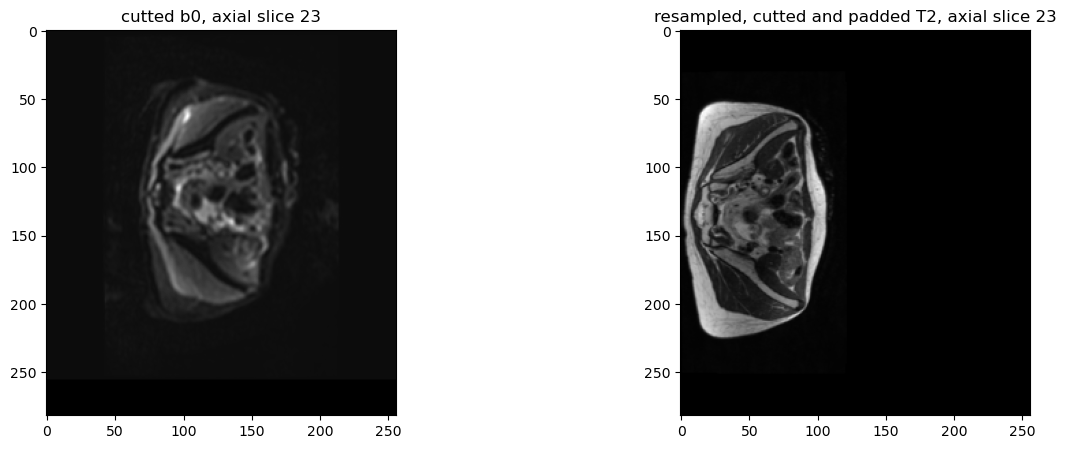

In [29]:
## padding T2 to have same size as b0
axial_resampled_T2_cut_pad_23, axial_b0_cut_pad_23 = padding(axial_resampled_T2_cut_23, axial_b0_cut_23)
print(axial_resampled_T2_cut_pad_23.shape)

fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.imshow(axial_b0_cut_pad_23, cmap='gray')
plt.title("cutted b0, axial slice 23")

plt.subplot(1,2,2)
plt.imshow(axial_resampled_T2_cut_pad_23, cmap="gray")
plt.title("resampled, cutted and padded T2, axial slice 23")

plt.show()

### joint entropy 

In [30]:
print(len(np.unique(axial_b0_cut_pad_23)))
print(len(np.unique(axial_resampled_T2_cut_pad_23)))

P_b0 = image_distribution(axial_b0_cut_pad_23, verbose=1)
P_T2 = image_distribution(axial_resampled_T2_cut_pad_23, verbose=1)

7077
27048
0.9999999999999999
1.0000000000000002


The number of gray values was too high so the algorithm was a bit slow. To make it faster, we will further normalize all the images to have gray values between 0 and 255. 

[[6656.    0.    0. ...    0.    0.    0.]
 [   0.    0.    0. ...    0.    0.    0.]
 [   0.    0.    0. ...    0.    0.    0.]
 ...
 [   0.    0.    0. ...    0.    0.    0.]
 [   0.    0.    0. ...    0.    0.    0.]
 [   0.    0.    0. ...    0.    0.    0.]]


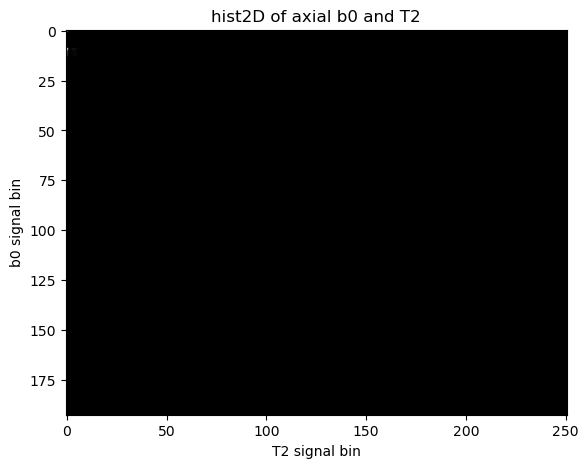

In [31]:
# Joint Entropy

axial_resampled_T2_cut_pad_norm_23 = cv2.normalize(axial_resampled_T2_cut_pad_23, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
axial_b0_cut_pad_norm_23 = cv2.normalize(axial_b0_cut_pad_23, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

#hist_b0_T2_0, xedges, yedges = np.histogram2d(axial_resampled_T2_cut_pad_23.ravel(), axial_b0_cut_pad_23.ravel(), bins=[len(np.unique(axial_resampled_T2_cut_pad_23)),len(np.unique(axial_b0_cut_23))])
hist_b0_T2_0, _, _ = np.histogram2d(axial_resampled_T2_cut_pad_norm_23.ravel(), axial_b0_cut_pad_norm_23.ravel(), bins=[len(np.unique(axial_resampled_T2_cut_pad_norm_23)),len(np.unique(axial_b0_cut_pad_norm_23))])

print(hist_b0_T2_0)
#print(xedges)
#print(yedges)


fig = plt.figure(figsize=(10,5))

plt.imshow(hist_b0_T2_0.T, cmap='gray')
plt.title("hist2D of axial b0 and T2")
plt.xlabel("T2 signal bin")
plt.ylabel("b0 signal bin")

plt.show()


In [32]:
## To see how many pairs of gray values we have (to have an idea of the distribution)

h,w = hist_b0_T2_0.shape
for i in range(h) :
    for j in range(w) :
        if hist_b0_T2_0[i,j] > 0 :
            print(f'i : {i}, j : {j}, val : {hist_b0_T2_0[i,j]}')

i : 0, j : 0, val : 6656.0
i : 0, j : 9, val : 16855.0
i : 0, j : 10, val : 5087.0
i : 0, j : 11, val : 4101.0
i : 0, j : 12, val : 3377.0
i : 0, j : 13, val : 602.0
i : 0, j : 14, val : 393.0
i : 0, j : 15, val : 513.0
i : 0, j : 16, val : 218.0
i : 0, j : 17, val : 202.0
i : 0, j : 18, val : 419.0
i : 0, j : 19, val : 212.0
i : 0, j : 20, val : 214.0
i : 0, j : 21, val : 394.0
i : 0, j : 22, val : 170.0
i : 0, j : 23, val : 171.0
i : 0, j : 24, val : 290.0
i : 0, j : 25, val : 161.0
i : 0, j : 26, val : 129.0
i : 0, j : 27, val : 144.0
i : 0, j : 28, val : 244.0
i : 0, j : 29, val : 106.0
i : 0, j : 30, val : 105.0
i : 0, j : 31, val : 214.0
i : 0, j : 32, val : 80.0
i : 0, j : 33, val : 102.0
i : 0, j : 34, val : 192.0
i : 0, j : 35, val : 102.0
i : 0, j : 36, val : 119.0
i : 0, j : 37, val : 217.0
i : 0, j : 38, val : 108.0
i : 0, j : 39, val : 115.0
i : 0, j : 40, val : 211.0
i : 0, j : 41, val : 117.0
i : 0, j : 42, val : 114.0
i : 0, j : 43, val : 249.0
i : 0, j : 44, val : 122.

In [33]:
print(np.unique(hist_b0_T2_0))

[0.0000e+00 1.0000e+00 2.0000e+00 3.0000e+00 4.0000e+00 5.0000e+00
 6.0000e+00 7.0000e+00 8.0000e+00 9.0000e+00 1.0000e+01 1.1000e+01
 1.2000e+01 1.3000e+01 1.4000e+01 1.5000e+01 1.6000e+01 1.7000e+01
 1.8000e+01 1.9000e+01 2.0000e+01 2.1000e+01 2.2000e+01 2.3000e+01
 2.4000e+01 2.5000e+01 2.6000e+01 2.7000e+01 2.8000e+01 2.9000e+01
 3.0000e+01 3.1000e+01 3.2000e+01 3.3000e+01 3.4000e+01 3.5000e+01
 3.6000e+01 3.7000e+01 3.8000e+01 3.9000e+01 4.0000e+01 4.1000e+01
 4.2000e+01 4.4000e+01 4.5000e+01 4.6000e+01 4.7000e+01 4.8000e+01
 4.9000e+01 5.0000e+01 5.1000e+01 5.2000e+01 5.3000e+01 5.4000e+01
 5.5000e+01 5.6000e+01 5.7000e+01 5.8000e+01 5.9000e+01 6.0000e+01
 6.2000e+01 6.3000e+01 6.4000e+01 6.5000e+01 6.7000e+01 6.8000e+01
 7.5000e+01 8.0000e+01 8.7000e+01 9.1000e+01 9.4000e+01 9.5000e+01
 1.0000e+02 1.0200e+02 1.0500e+02 1.0600e+02 1.0800e+02 1.0900e+02
 1.1400e+02 1.1500e+02 1.1700e+02 1.1900e+02 1.2200e+02 1.2900e+02
 1.4400e+02 1.6100e+02 1.6300e+02 1.7000e+02 1.7100e+02 1.7700

The 2D histogram is actually not completely black

[[8.80327398 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


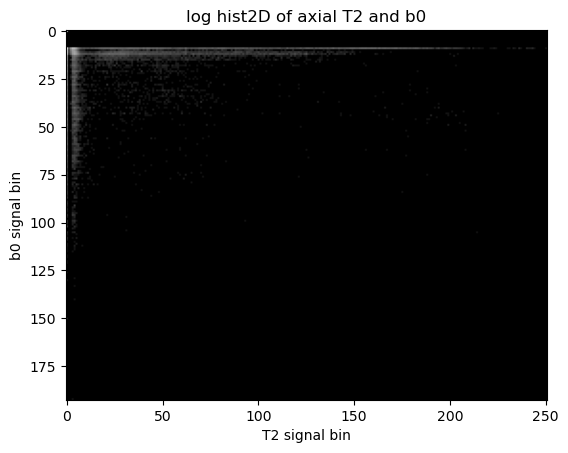

In [34]:
## trying to better see the results (to better differenciate the pixels different from zero) 
## --> This cell is not usefull if the images were not normalized before. The resolution will still
## be to small, we won't distinguish any pixels in the large matrix

hist_b0_T2_0_log = np.zeros(hist_b0_T2_0.shape)
non_zeros = hist_b0_T2_0 != 0
hist_b0_T2_0_log[non_zeros] = np.log(hist_b0_T2_0[non_zeros])

plt.imshow(hist_b0_T2_0_log.T, cmap='gray')
plt.title("log hist2D of axial T2 and b0")
plt.xlabel('T2 signal bin')
plt.ylabel('b0 signal bin')

print(hist_b0_T2_0_log)

entropy img1 :  3.2988304538531685
entropy img2 :  3.3161135157349997
entropy jointe :  3.969133055285268
nmi between 90 and a : 2.6458109143029
entropy img1 :  3.2988304538531685
entropy img2 :  3.1685342749066723
entropy jointe :  5.873100225853377
nmi between 90 and b : 0.5942645029064639
entropy img1 :  3.2988304538531685
entropy img2 :  3.2988304538531685
entropy jointe :  3.290814830930452
nmi between 90 and 90 : 3.306846076775885


Text(0, 0.5, 'b0 signal bin')

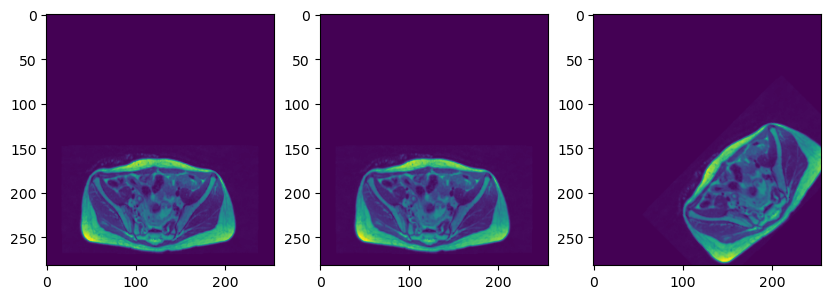

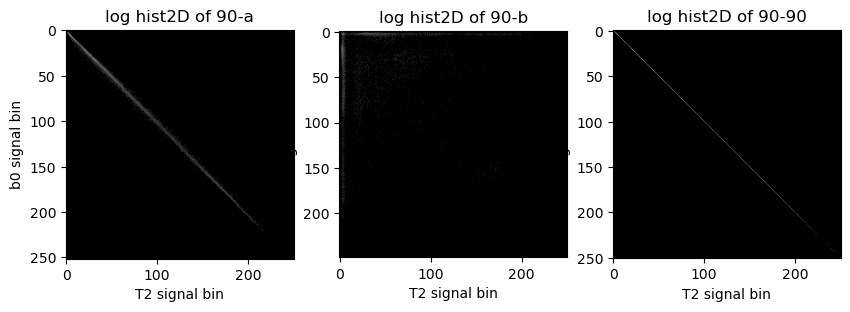

In [72]:
rotation_90 = transform_image_rotation(90,axial_resampled_T2_cut_pad_norm_23)
rotation_a = transform_image_rotation(0.1,rotation_90)
rotation_b = transform_image_rotation(45,rotation_90)

plt.figure(figsize=(10,20))
plt.subplot(1,3,1)
plt.imshow(rotation_90)
plt.subplot(1,3,2)
plt.imshow(rotation_a)
plt.subplot(1,3,3)
plt.imshow(rotation_b)

print(f'nmi between 90 and a : {mutual_information(rotation_90, rotation_a, verbose=1)}')
print(f'nmi between 90 and b : {mutual_information(rotation_90, rotation_b, verbose=1)}')
print(f'nmi between 90 and 90 : {mutual_information(rotation_90, rotation_90, verbose=1)}')

joint_hist_90_a, _, _ = np.histogram2d(rotation_90.ravel(), rotation_a.ravel(), bins=[len(np.unique(rotation_90)),len(np.unique(rotation_a))])
joint_hist_90_a_log = np.zeros(joint_hist_90_a.shape)
non_zeros = joint_hist_90_a != 0
joint_hist_90_a_log[non_zeros] = np.log(joint_hist_90_a[non_zeros])

joint_hist_90_b, _, _ = np.histogram2d(rotation_90.ravel(), rotation_b.ravel(), bins=[len(np.unique(rotation_90)),len(np.unique(rotation_b))])
joint_hist_90_b_log = np.zeros(joint_hist_90_b.shape)
non_zeros = joint_hist_90_b != 0
joint_hist_90_b_log[non_zeros] = np.log(joint_hist_90_b[non_zeros])

joint_hist_90_90, _, _ = np.histogram2d(rotation_90.ravel(), rotation_90.ravel(), bins=[len(np.unique(rotation_90)),len(np.unique(rotation_90))])
joint_hist_90_90_log = np.zeros(joint_hist_90_90.shape)
non_zeros = joint_hist_90_90 != 0
joint_hist_90_90_log[non_zeros] = np.log(joint_hist_90_90[non_zeros])

plt.figure(figsize=(10,20))
plt.subplot(1,3,1)
plt.imshow(joint_hist_90_a_log.T, cmap='gray')
plt.title("log hist2D of 90-a")
plt.xlabel('T2 signal bin')
plt.ylabel('b0 signal bin')

plt.subplot(1,3,2)
plt.imshow(joint_hist_90_b_log.T, cmap='gray')
plt.title("log hist2D of 90-b")
plt.xlabel('T2 signal bin')
plt.ylabel('b0 signal bin')

plt.subplot(1,3,3)
plt.imshow(joint_hist_90_90_log.T, cmap='gray')
plt.title("log hist2D of 90-90")
plt.xlabel('T2 signal bin')
plt.ylabel('b0 signal bin')

### Mutual information

In [194]:
# Mutual information function (using skimage.measure.shannon_entropy)

def mutual_information(img1, img2, verbose=0):
    
    # Calculate joint histogram
    joint_hist, _, _ = np.histogram2d(img1.ravel(), img2.ravel(), bins=[len(np.unique(img1)),len(np.unique(img2))])    
    joint_hist /= np.sum(joint_hist)
    joint_dist = joint_hist.ravel()
    
    # Shannon entropy for each distribution
    H_img1 = skimage.measure.shannon_entropy(img1)
    H_img2 = skimage.measure.shannon_entropy(img2)
    H_joint = scipy.stats.entropy(joint_dist, base=2)
    
    if verbose > 0 : 
        print("entropy img1 : ", H_img1)
        print("entropy img2 : ", H_img2)
        print("entropy jointe : ", H_joint)
    

    # Calculate normalized mutual information
    if H_joint == 0 :
        nmi = H_img1 + H_img2
    else : 
        nmi = (H_img1 + H_img2) - H_joint
        
    #print(nmi)
    
    return -nmi  


In [193]:
# Mutual information function

def mutual_information(img1, img2, verbose=0):
    # Calculate histogram for each image
    dist1 = image_distribution(img1)
    dist2 = image_distribution(img2)

    # Calculate joint histogram
    joint_hist, _, _ = np.histogram2d(img1.ravel(), img2.ravel(), bins=[len(np.unique(img1)),len(np.unique(img2))])    
    joint_hist /= np.sum(joint_hist)
    joint_dist = joint_hist.ravel()
    
    # Shannon entropy for each distribution
    H_img1 = scipy.stats.entropy(dist1, base=2)
    H_img2 = scipy.stats.entropy(dist2, base=2)
    H_joint = scipy.stats.entropy(joint_dist, base=2)
    
    if verbose > 0 : 
        print("entropy img1 : ", H_img1)
        print("entropy img2 : ", H_img2)
        print("entropy jointe : ", H_joint)
    

    # Calculate normalized mutual information
    if H_joint == 0 :
        nmi = H_img1 + H_img2
    else : 
        nmi = (H_img1 + H_img2) - H_joint
        
    #print(nmi)
    
    return nmi  


In [131]:
### Property of mutual information : MI(A,A) = H(A)   ---> OK ? 
print(f'MI between rotation_b and rotation_b : {mutual_information(rotation_b, rotation_b, verbose=1)}')
dist_b = image_distribution(rotation_b)
print(f'Shannon entropy of rotation_b : {scipy.stats.entropy(dist_b, base=2)}')

entropy img1 :  3.1685342749066714
entropy img2 :  3.1685342749066714
entropy jointe :  3.151182203069484
MI between rotation_b and rotation_b : 3.185886346743859
Shannon entropy of rotation_b : 3.1685342749066723


In [115]:
### Property of mutual information : MI(A,B) = MI(B,A)  ---> OK

print(f'MI between rotation_90 and rotation_b : {mutual_information(rotation_90, rotation_b)}')
print(f'MI between rotation_b and rotation_90 : {mutual_information(rotation_b, rotation_90)}')


MI between rotation_90 and rotation_b : 0.5942645029064639
MI between rotation_b and rotation_90 : 0.5942645029064622


In [132]:
### Property of mutual information : MI(A,B) <= H(A) and MI(A,B) <= H(B) --> OK

print(f'MI between rotation_90 and b0 : {mutual_information(rotation_90, axial_b0_cut_pad_norm_23, verbose=1)}')

entropy img1 :  3.2988304538531685
entropy img2 :  4.063769381315207
entropy jointe :  6.911293836599867
MI between rotation_90 and b0 : 0.4513059985685075


### Gradient descent algorithm

#### Translation and rotation at the same time

In [84]:
# Define transformation function (cv2.warpAffine() implicitly uses linear interpolation)

def transform_image(params, img):
    rows, cols = img.shape
    dx, dy, theta = params
    #print(f'dx: {dx}, dy: {dy}, theta: {theta}')

    M = cv2.getRotationMatrix2D((cols/2, rows/2), theta, 1)
    M[0,2] += dx
    M[1,2] += dy
    
    return cv2.warpAffine(img.copy(), M, (cols, rows))

In [85]:
# Define cost function for optimization

def cost_function(params, img1, img2):
    transformed_img = transform_image(params, img1)
    return mutual_information(transformed_img, img2)

In [185]:
# Gradient calculation for the cost function

def gradient(params, img1, img2, epsilon=[2.,2.,1.]):
    ## Calculate gradient for each param
    grad = np.zeros_like(params)
    
    for i in range(len(params)):
        if i < 2 :
            params_pos = params.copy()
            params_neg = params.copy()
            params_pos[i] += epsilon[i]
            params_neg[i] -= epsilon[i]
            delta = 2 * epsilon[i]
        else :
            params_pos = params.copy()
            params_neg = params.copy()
            params_pos[i] += epsilon[i]
            delta = epsilon[i]
        
        cost_pos = cost_function(params_pos, img1, img2)
        cost_neg = cost_function(params_neg, img1, img2)
        
        #print(f'cost_pos : {cost_pos}, cost_neg : {cost_neg}, delta : {delta}')
        
        #print((cost_pos - cost_neg) / delta)
        
        grad[i] = (cost_pos - cost_neg) / delta
        
    return grad


In [183]:
# Gradient descent optimization

def gradient_descent(cost_func, grad_func, initial_params, img1, img2, learning_rate=[5.,5.,1.], max_iters=1000):
    params = initial_params.copy()
    
    for i in range(max_iters):
        grads = grad_func(params, img1, img2)
        #print(grads)
        params[0] += np.ceil(learning_rate[0] * grads[0])
        params[1] += np.ceil(learning_rate[1] * grads[1])
        params[2] += learning_rate[2] * grads[2]
        
        # Print the cost every few iterations
        if i % 100 == 0:
            cost = cost_func(params, img1, img2)
            print(f"Iteration {i}: Cost = {cost}, params = {params}")
    
    return params

#### Translation and rotation loops are separated 

In [36]:
# Define transformation function for translation only 

def transform_image_translation(params, img):
    rows, cols = img.shape
    dx, dy= params
    #print(f'dx: {dx}, dy: {dy}')

    M = np.float32([[1, 0, dx], [0, 1, dy]])
    
    return cv2.warpAffine(img.copy(), M, (cols, rows))

In [66]:
def transform_image_rotation(theta, img):
    rows, cols = img.shape
    #print(f'In transform_image_rotation : theta = {theta}, rows = {rows}, cols = {cols}')
    
    M = cv2.getRotationMatrix2D((cols/2, rows/2), theta, 1)
    #print(M)
    
    return cv2.warpAffine(img.copy(), M, (cols, rows))

In [41]:
# Define your cost function for optimization, translation only

def cost_function_translation(params, img1, img2):
    transformed_img = transform_image_translation(params, img1)
    return mutual_information(transformed_img, img2)

In [68]:
# Define your cost function for optimization, rotation only

def cost_function_rotation(theta, img1, img2):
    #print(f'In cost_function_rotation : {theta}')
    #transformed_img = transform_image_rotation(theta[0], img1)
    transformed_img = transform_image_rotation(theta, img1)
    return mutual_information(transformed_img, img2)

In [44]:
# Gradient calculation for the cost function for translation only

def gradient_translation(params, img1, img2, epsilon=[1.,1.]):
    ## Calculate gradient for each param
    grad = np.zeros_like(params)
    
    for i in range(len(params)):
        params_pos = params.copy()
        params_neg = params.copy()
        params_pos[i] += epsilon[i]
        params_neg[i] -= epsilon[i]
        delta = 2 * epsilon[i]
        
        cost_pos = cost_function_translation(params_pos, img1, img2)
        cost_neg = cost_function_translation(params_neg, img1, img2)
        
        #print(f'cost_pos : {cost_pos}, cost_neg : {cost_neg}, delta : {delta}')
        
        #print((cost_pos - cost_neg) / delta)
        
        grad[i] = (cost_pos - cost_neg) / delta
        
    return grad


In [160]:
# Gradient calculation for the cost function for rotation only

def gradient_rotation(theta, img1, img2, epsilon=1.):
    ## Calculate gradient for each param
    grad = 0
    
    param_pos = theta + epsilon
    param_neg = theta - epsilon
    delta = 2 * epsilon
        
    cost_pos = cost_function_rotation(param_pos, img1, img2)
    cost_neg = cost_function_rotation(param_neg, img1, img2)
        
    #print(f'cost_pos : {cost_pos}, cost_neg : {cost_neg}, delta : {delta}')
        
    #print((cost_pos - cost_neg) / delta)
        
    grad = (cost_pos - cost_neg) / delta
        
    return grad


In [47]:
# Gradient descent optimization for translation only

def gradient_descent_translation(cost_func, grad_func, initial_params, img1, img2, learning_rate=[5.,5.], max_iters=100):
    params = initial_params.copy()
    
    for i in range(max_iters):
        grads = grad_func(params, img1, img2)
        d0 = np.ceil(learning_rate[0] * grads[0])
        d1 = np.ceil(learning_rate[1] * grads[1])
        params[0] += d0
        params[1] += d1
        
        # Stop condition
        if (d0 == 0) and (d1 == 0) :
            cost = cost_func(params, img1, img2)
            print(f"STOP : Iteration {i}: Cost = {cost}, translation_params = {params}")
            return params
        
        # Print the cost every few iterations
        if i % 10 == 0:
            cost = cost_func(params, img1, img2)
            print(f"Iteration {i}: Cost = {cost}, translation_params = {params}")
    
    return params

In [146]:
# Gradient descent optimization for rotation only

def gradient_descent_rotation(cost_func, grad_func, initial_theta, img1, img2, learning_rate=10., max_iters=101):
    
    for i in range(max_iters):
        grad = grad_func(initial_theta, img1, img2)
        #print(f'rotation grad = {grad}')
        d_theta = learning_rate * grad
        initial_theta += d_theta
        
        if d_theta == 0 :
            cost = cost_func(initial_theta, img1, img2)
            print(f"STOP : Iteration {i}: Cost = {cost}, teta = {initial_theta}")
            return initial_theta
        
        # Print the cost every few iterations
        if i % 10 == 0:
            cost = cost_func(initial_theta, img1, img2)
            print(f"Iteration {i}: Cost = {cost}, teta = {initial_theta}")
            
            #test_transformed = transform_image_rotation(initial_theta, img1)
            #joint_hist, _, _ = np.histogram2d(test_transformed.ravel(), img2.ravel(), bins=[len(np.unique(test_transformed)),len(np.unique(img2))])
            #joint_hist_log = np.zeros(joint_hist.shape)
            #non_zeros = joint_hist != 0
            #joint_hist_log[non_zeros] = np.log(joint_hist[non_zeros])

            #plt.figure()
            #plt.imshow(joint_hist_log.T, cmap='gray')
            #plt.title("log hist2D of axial T2 and b0")
            #plt.xlabel('T2 signal bin')
            #plt.ylabel('b0 signal bin')
    
    return initial_theta

## Tests

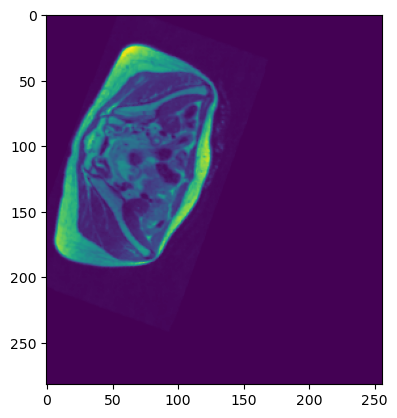

In [144]:
test_transform = transform_image([10,0,-20], axial_resampled_T2_cut_pad_norm_23)
plt.imshow(test_transform)

#### A test that doesn't work anymore for still unknown reason

Iteration 0: Cost = 0.6576085178858104, translation_params = [0. 1.]
Iteration 10: Cost = 0.6884570771010488, translation_params = [ 0. 11.]
Iteration 20: Cost = 0.7321428226028814, translation_params = [ 0. 21.]
Iteration 30: Cost = 0.7565276708490121, translation_params = [ 0. 31.]
STOP : Iteration 32: Cost = 0.7567033819718842, translation_params = [ 0. 32.]


TypeError: Argument 'angle' can not be safely parsed to 'double'

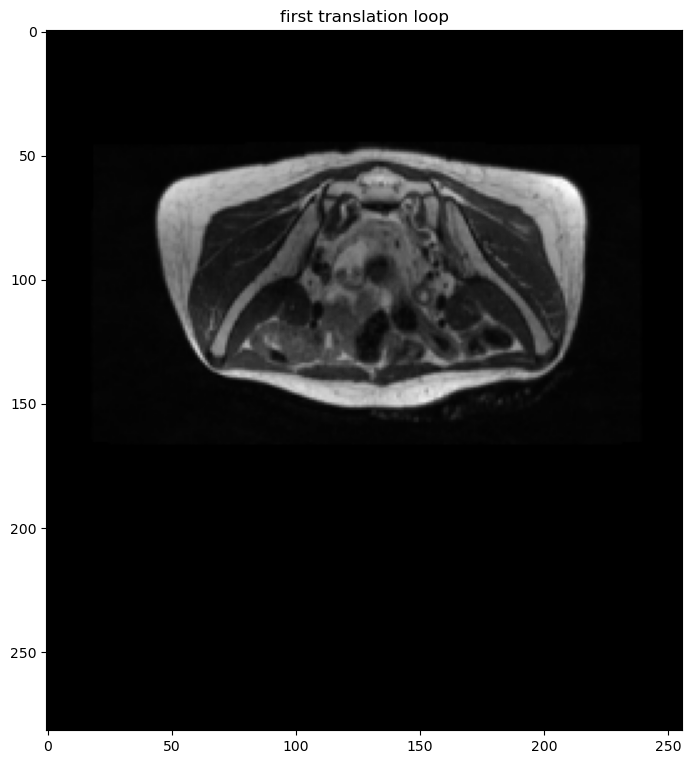

In [70]:
###############################################################
#########         THERE IS AN ERROR IDK WHY          ##########
###############################################################

rows, cols = axial_resampled_T2_cut_pad_norm_23.shape
plt.figure(figsize = (20,20))

### Initial parameters
initial_translation = np.array([0.,0.])
#initial_teta = np.array([0.])
initial_teta = np.array(0.)
#modified_image = axial_resampled_T2_cut_pad_norm_23.copy()
modified_image = test_transform.copy()
target_image = axial_b0_cut_pad_norm_23.copy()


### First translation optimization
optimized_translation = gradient_descent_translation(cost_function_translation, gradient_translation, initial_translation, modified_image, target_image)
M1 = np.float32([[1, 0, optimized_translation[0]], [0, 1, optimized_translation[1]], [0, 0, 1]])

optimized_params = M1
M = optimized_params[:2,:]
semi_result = cv2.warpAffine(test_transform, M, (cols, rows))
plt.subplot(2,2,1)
plt.imshow(semi_result, cmap='gray')
plt.title("first translation loop")


### First rotation optimization
registered_img = transform_image_translation(optimized_translation, modified_image)
optimized_teta = gradient_descent_rotation(cost_function_rotation, gradient_rotation, initial_teta, registered_img, target_image)
print(f'opt theta : {optimized_teta}')
M2 = cv2.getRotationMatrix2D((cols/2, rows/2), optimized_teta, 1)
M2 = np.vstack((M2,[0,0,1]))

#registered_img = transform_image_translation(optimized_translation, test_transform)
#result = minimize(cost_function_rotation, initial_teta, args=(registered_img,axial_b0_cut_pad_norm_23), method='BFGS')  # Change method as needed
#optimized_teta = result.x[0]
#print(f'opt theta : {optimized_teta}')
#M2 = cv2.getRotationMatrix2D((cols/2, rows/2), optimized_teta, 1)
#M2 = np.vstack((M2,[0,0,1]))

optimized_params = np.matmul(M1,M2)
M = optimized_params[:2,:]
semi_result = cv2.warpAffine(test_transform, M, (cols, rows))
plt.subplot(2,2,2)
plt.imshow(semi_result, cmap='gray')
plt.title("first rotation loop")



# Second translation optimization
semi_registered_img = transform_image_rotation(optimized_teta, registered_img)
optimized_translation = gradient_descent_translation(cost_function_translation, gradient_translation, initial_translation, semi_registered_img, target_image)
M3 = np.float32([[1, 0, optimized_translation[0]], [0, 1, optimized_translation[1]], [0, 0, 1]])

optimized_params = np.matmul(np.matmul(M1,M2),M3)
M = optimized_params[:2,:]
semi_result = cv2.warpAffine(test_transform, M, (cols, rows))
plt.subplot(2,2,3)
plt.imshow(semi_result, cmap='gray')
plt.title("second translation loop")

# Perform optimization on rotation using gradient descent
registered_img = transform_image_translation(optimized_translation, semi_registered_img)
optimized_teta = gradient_descent_rotation(cost_function_rotation, gradient_rotation, initial_teta, registered_img, target_image)
print(f'opt theta : {optimized_teta}')
M4 = cv2.getRotationMatrix2D((cols/2, rows/2), optimized_teta, 1)
M4 = np.vstack((M4,[0,0,1]))

#registered_img = transform_image_translation(optimized_translation, test_transform)
#result = minimize(cost_function_rotation, initial_teta, args=(registered_img,axial_b0_cut_pad_norm_23), method='BFGS')  # Change method as needed
#optimized_teta = result.x[0]
#print(f'opt theta : {optimized_teta}')
#M4 = cv2.getRotationMatrix2D((cols/2, rows/2), optimized_teta, 1)
#M4 = np.vstack((M2,[0,0,1]))

optimized_params = np.matmul(np.matmul(np.matmul(M1,M2),M3),M4)

print(optimized_params)

M = optimized_params[:2,:]
final_result = cv2.warpAffine(test_transform, M, (cols, rows))
# Show the registered image
plt.subplot(2,2,4)
plt.imshow(final_result, cmap='gray')
plt.title("second rotation loop")


#### Optimized test in a loop of 10 iterations to compute the best translation then the best rotation

Iteration 0: Cost = 0.6486378889455473, translation_params = [1. 1.]
Iteration 10: Cost = 0.7612826290833201, translation_params = [11. 10.]
Iteration 20: Cost = 0.8925294376202446, translation_params = [21. 14.]
Iteration 30: Cost = 1.01373743453194, translation_params = [31. 16.]
Iteration 40: Cost = 1.1397577869062836, translation_params = [41. 16.]
STOP : Iteration 44: Cost = 1.1494225804364175, translation_params = [44. 16.]
Iteration 0: Cost = 1.149084760471669, teta = 0.018394638598713264
Iteration 10: Cost = 1.1523300551219053, teta = 0.18696248787409253
Iteration 20: Cost = 1.1563961960773552, teta = 0.3450106421293384
Iteration 30: Cost = 1.1541958499114129, teta = 0.4508904464260226
Iteration 40: Cost = 1.1548549676519517, teta = 0.5871576395713802
Iteration 50: Cost = 1.1525073418535543, teta = 0.6693412281073261
Iteration 60: Cost = 1.156799866919111, teta = 0.6781449166051781
Iteration 70: Cost = 1.1569568833902881, teta = 0.6538857084841068
Iteration 80: Cost = 1.1558435

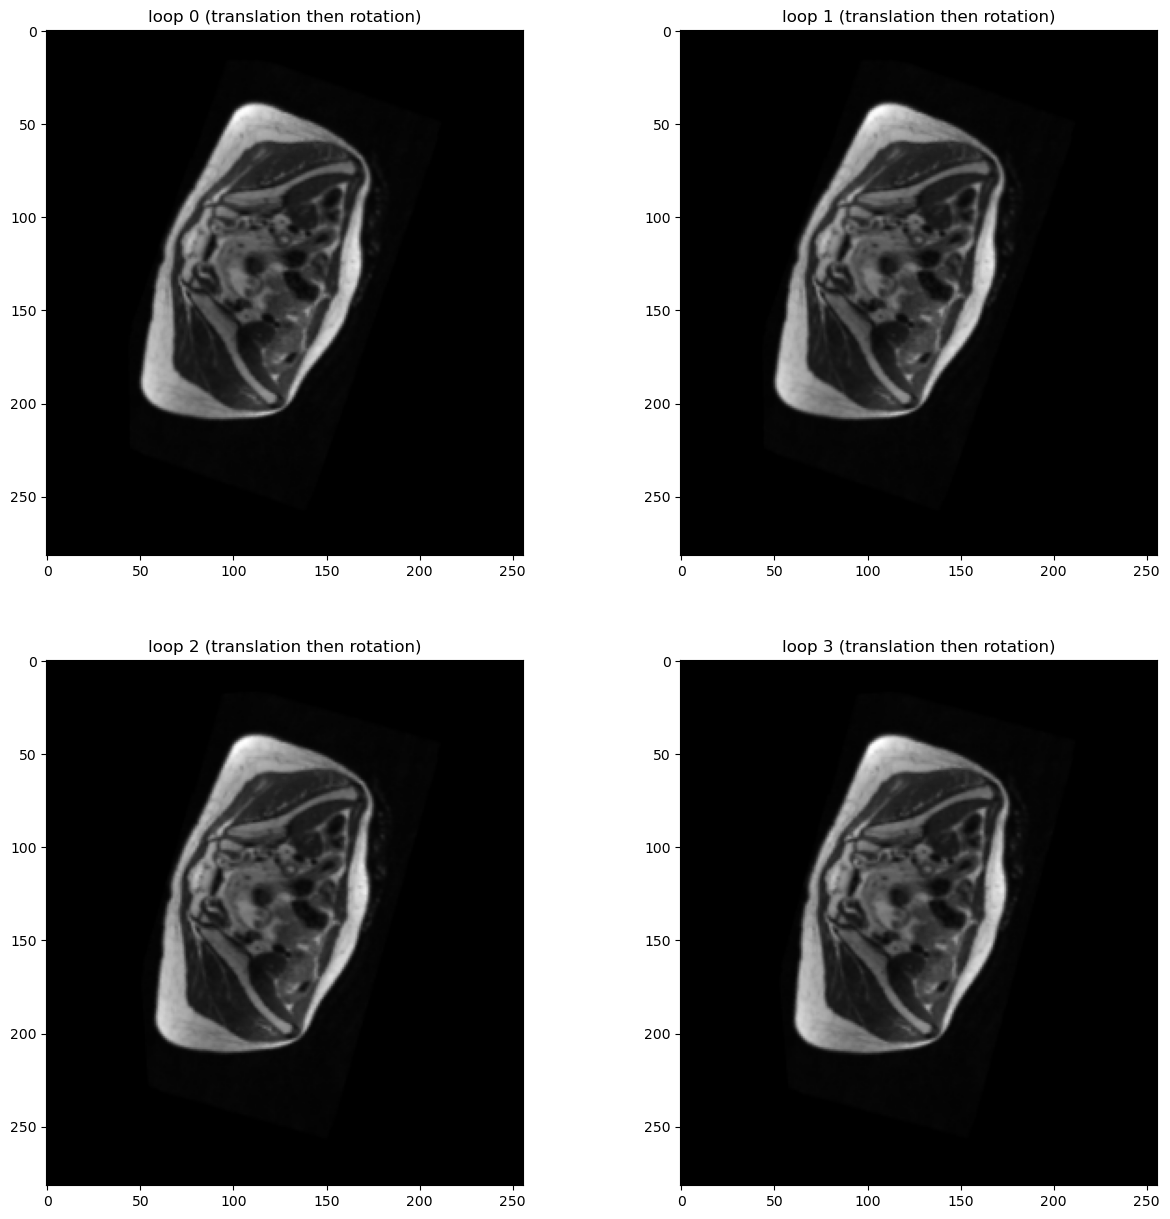

In [156]:
rows, cols = axial_resampled_T2_cut_pad_norm_23.shape
plt.figure(figsize = (15,15))

## Initial translation transformation paramters
initial_translation = np.array([0.,0.])
initial_teta = 0
#semi_registered_img = axial_resampled_T2_cut_pad_norm_23.copy()
semi_registered_img = test_transform.copy()
target_image = axial_b0_cut_pad_norm_23.copy()
optimized_params = np.identity(3)

for i in range(4) :
    ## Perform optimization on translation using gradient descent
    optimized_translation = gradient_descent_translation(cost_function_translation, gradient_translation, initial_translation, semi_registered_img, target_image)
    M1 = np.float32([[1, 0, optimized_translation[0]], [0, 1, optimized_translation[1]], [0, 0, 1]])
    optimized_params = np.matmul(M1, optimized_params)

    ## Perform optimization on rotation using gradient descent
    registered_img = transform_image_translation(optimized_translation, semi_registered_img)
    optimized_teta = gradient_descent_rotation(cost_function_rotation, gradient_rotation, initial_teta, registered_img, target_image)
    M2 = cv2.getRotationMatrix2D((cols/2, rows/2), optimized_teta, 1)
    M2 = np.vstack((M2,[0,0,1]))
    optimized_params = np.matmul(M2, optimized_params)
    
    semi_registered_img = transform_image_rotation(optimized_teta, registered_img)
    
    M = optimized_params[:2,:]
    #semi_result = cv2.warpAffine(axial_resampled_T2_cut_pad_norm_23, M, (cols, rows))
    semi_result = cv2.warpAffine(test_transform, M, (cols, rows))
    plt.subplot(2,2,i+1)
    plt.imshow(semi_result, cmap='gray')
    plt.title(f'loop {i} (translation then rotation)')
    
#result = cv2.warpAffine(test_transform.copy(), optimized_params, (cols, rows))
#plt.imshow(result, cmap='gray')

In [157]:
print(M)
print(np.arccos(M[0,0]))

[[ 0.99647214  0.08392421 40.79226626]
 [-0.08392421  0.99647214 23.09730373]]
0.08402303867814401


#### An old that compute the best translation and rotation simultaneously (using gradient descent)

Iteration 0: Cost = 0.6486378889455473, params = [1.         1.         0.00403855]
Iteration 100: Cost = 1.1565810993453525, params = [49.         16.          0.13658076]
Iteration 200: Cost = 1.153877501278747, params = [49.         16.          0.13521992]
Iteration 300: Cost = 1.1564287954966463, params = [49.         16.          0.13674868]
Iteration 400: Cost = 1.156231489017518, params = [49.         16.          0.13744023]
Iteration 500: Cost = 1.156308851557755, params = [49.         16.          0.13760032]
Iteration 600: Cost = 1.1565489297852958, params = [49.         16.          0.13690194]
Iteration 700: Cost = 1.1562918071554105, params = [49.         16.          0.13737667]
Iteration 800: Cost = 1.1567643553396536, params = [49.         16.          0.13601348]
Iteration 900: Cost = 1.1562041269008247, params = [49.         16.          0.13754232]
[49.         16.          0.13776655]


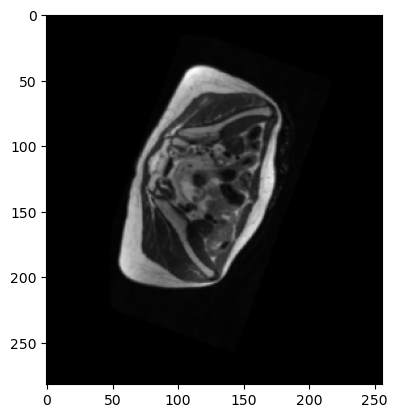

In [186]:
#### Translation and rotation at the same time

# Initial transformation parameters
initial_params = np.array([0., 0., 0.])
#modified_image = axial_resampled_T2_cut_pad_norm_23.copy()
modified_image = test_transform.copy()
target_image = axial_b0_cut_pad_norm_23.copy()

# Perform optimization using gradient descent
optimized_params = gradient_descent(cost_function, gradient, initial_params, modified_image, target_image)

print(optimized_params)

# Apply optimized transformation to align images
registered_img = transform_image(optimized_params, test_transform)
#registered_img = transform_image(optimized_params, axial_resampled_T2_cut_pad_norm_23)

# Show the registered image
plt.imshow(registered_img, cmap='gray')

#### An old that compute the best translation and rotation simultaneously (using cv2.optimize.minimize) : doesn't work

[0. 0. 0.]


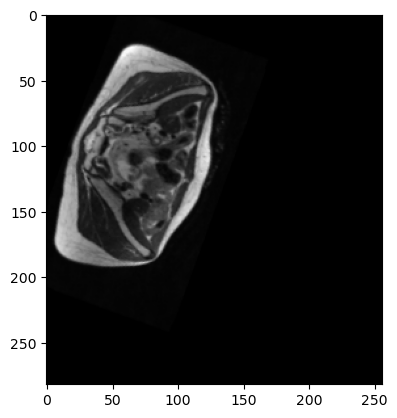

In [200]:
##### Algorithm doesn't work with the minimize function

# Initial transformation parameters
initial_params = np.array([0.,0.,0.])
#imgs  = [axial_resampled_T2_cut_pad_23, axial_b0_cut_pad_23]

#options={'maxiter':10000}

# Perform optimization using gradient descent
result = minimize(cost_function, initial_params, args=(test_transform.copy(),axial_b0_cut_pad_norm_23), method='CG')  # Change method as needed

# Obtain optimized parameters
optimized_params = result.x
print(optimized_params)

# Apply optimized transformation to align images
registered_img = transform_image(optimized_params, test_transform)

# Show the registered image
plt.imshow(registered_img, cmap='gray')

#### Verification that the cv2.warpAffine function is rotated the image from its center

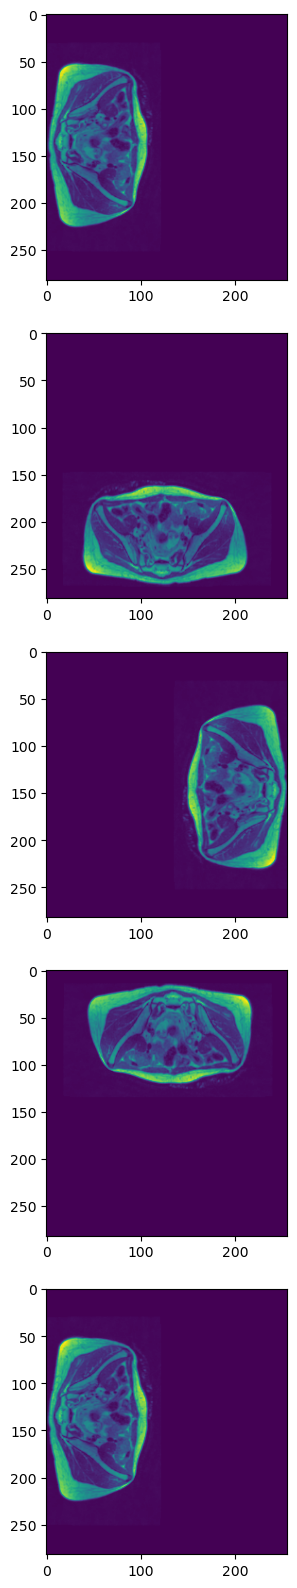

In [353]:
plt.figure(figsize=(10,20))
plt.subplot(5,1,1)
plt.imshow(axial_resampled_T2_cut_pad_norm_23)
plt.subplot(5,1,2)
test_transform_rotation = transform_image_rotation(90,axial_resampled_T2_cut_pad_norm_23)
plt.imshow(test_transform_rotation)
plt.subplot(5,1,3)
test_transform_rotation = transform_image_rotation(90,test_transform_rotation)
plt.imshow(test_transform_rotation)
plt.subplot(5,1,4)
test_transform_rotation = transform_image_rotation(90,test_transform_rotation)
plt.imshow(test_transform_rotation)
plt.subplot(5,1,5)
test_transform_rotation = transform_image_rotation(90,test_transform_rotation)
plt.imshow(test_transform_rotation)
